In [1]:
import sys
import os

# Add the workspace directory to the system path
sys.path.append(os.path.abspath('..'))

# Now you should be able to import the class
from model import preprocess_data
from model.train import HST

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2024-08-19 14:49:16.296287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 14:49:17.049238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


In [2]:
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-08-14 18:33:24.050679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-14 18:33:24.189513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-14 18:33:24.189888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
%matplotlib inline

In [8]:
import tensorflow as tf
tf.data.experimental.save(
    train_dataset, path= "train_dataset"
)

In [3]:
loaded = tf.data.experimental.load(
    "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_odom"
)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


2024-08-19 14:49:51.622153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:49:51.655381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:49:51.655842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:49:51.658984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 14:49:51.659504: I tensorflow/compile

In [4]:
loaded = tf.data.experimental.load(
    "/home/annalena/PedestrianTrajectoryPrediction/test_synthetic_2d_l3/content/test_synthetic_2d_l3"
)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


2024-08-13 15:59:47.920586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-13 15:59:47.973878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-13 15:59:47.974402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-13 15:59:47.978641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-13 15:59:47.979393: I tensorflow/compile

In [8]:
import datetime
import tensorflow as tf

ckpt_best_dir = "/home/annalena/PedestrianTrajectoryPrediction/odom_orig/ckpts_best/ckpt"

def test_model(checkpoint_dir, test_dataset):
    
    model = HST(15)  # Initialize the model architecture
    optimizer = tf.keras.optimizers.Adam()
    
    # Create a checkpoint object
    checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
    
    # Restore the latest checkpoint
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        checkpoint.restore(latest_checkpoint)
        print(f"Restored checkpoint from {latest_checkpoint}")
    else:
        print("No checkpoint found.")
        return
    
    # Run a forward pass with a batch from the test dataset
    for (batch_x1, batch_x2) in test_dataset.take(1):
        input_batch = (batch_x1, batch_x2)
        output_dict, pred = model(input_batch, training=False)
        #print(output)
        break
    return output_dict, pred, input_batch


In [9]:
output_dict, pred, input = test_model(ckpt_best_dir, loaded)

Restored checkpoint from /home/annalena/PedestrianTrajectoryPrediction/odom_orig/ckpts_best/ckpt/ckpt-5


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16053318953697717525
2024-08-19 14:50:57.539844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [12]:
%matplotlib inline

In [10]:
pred["mixture_logits"]

<tf.Tensor: shape=(32, 1, 5), dtype=float32, numpy=
array([[[ 0.02432423,  0.00681269, -0.18814166,  0.02405232,
          0.01745496]],

       [[ 0.017151  ,  0.01105021, -0.01074711,  0.01848441,
          0.01369796]],

       [[ 0.01677329,  0.00982777, -0.01598969,  0.01798374,
          0.01342723]],

       [[ 0.02388332,  0.00765011, -0.14193496,  0.02361578,
          0.01734103]],

       [[ 0.02389524,  0.00771607, -0.13930675,  0.02361906,
          0.0173617 ]],

       [[ 0.02598218,  0.00895206, -0.13799201,  0.02519631,
          0.0188992 ]],

       [[ 0.02410233,  0.0074788 , -0.15542002,  0.0238154 ,
          0.0174587 ]],

       [[ 0.02122329, -0.01538681, -0.18489702,  0.02198822,
          0.01540645]],

       [[ 0.0280371 ,  0.0092173 , -0.20382701,  0.0276411 ,
          0.02075588]],

       [[ 0.02626863,  0.00761265, -0.2132851 ,  0.02597758,
          0.01900001]],

       [[ 0.02389651,  0.00763917, -0.14244674,  0.02362627,
          0.01734463]],

  

In [15]:
pred["position"][0,:,0,:2]

<tf.Tensor: shape=(15, 2), dtype=float32, numpy=
array([[ 2.3242922, -1.5897198],
       [ 2.201498 , -1.5400065],
       [ 2.212193 , -1.5060606],
       [ 2.247127 , -1.5865732],
       [ 2.3829427, -1.5651078],
       [ 2.3754601, -1.7394959],
       [ 2.1723154, -1.4381802],
       [ 2.1730485, -1.4274968],
       [ 2.1889954, -1.4192437],
       [ 2.1895776, -1.4282141],
       [ 2.167231 , -1.4245923],
       [ 2.1765244, -1.4306911],
       [ 2.174631 , -1.4288155],
       [ 2.1787014, -1.436587 ],
       [ 2.1809292, -1.4390249]], dtype=float32)>

/tmp/ipykernel_11388/3991637300.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


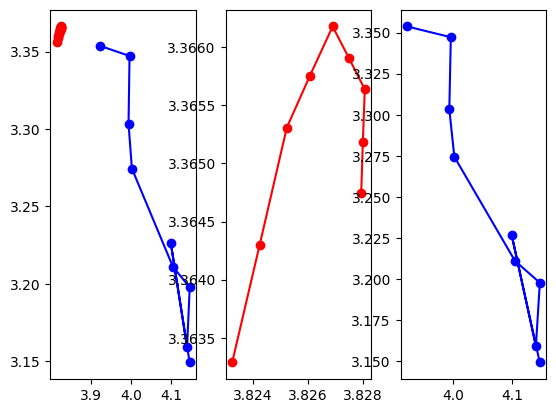

In [21]:
import matplotlib.pyplot as plt 
import numpy as np 

idx = 5

mode =1

ground_truth = input[0][idx][:,:2].numpy()
prediction = pred["position"][idx,:,mode,:2].numpy()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.plot(ground_truth[1:,0], ground_truth[1:,1], 'ro-')
ax1.plot(prediction[6:,0], prediction[6:,1],'bo-')
ax2.plot(ground_truth[6:,0], ground_truth[6:,1], 'ro-')
ax3.plot(prediction[6:,0], prediction[6:,1],'bo-')
fig.show()

In [10]:
prediction

array([[-0.21553525, -0.03838827],
       [-0.16171409,  0.07452854],
       [-0.1618135 ,  0.07464612],
       [-0.16172779,  0.0746796 ],
       [-0.16172747,  0.07479997],
       [-0.16176964,  0.07472967],
       [-0.1637809 ,  0.02403552],
       [-0.16363353,  0.02353285],
       [-0.16364695,  0.02300084],
       [-0.16372512,  0.02258127],
       [-0.16382676,  0.02248896],
       [-0.16380595,  0.02272726],
       [-0.16376704,  0.02319433],
       [-0.16377345,  0.02361044],
       [-0.16379225,  0.02374719]], dtype=float32)

In [11]:
ground_truth

array([[-9.91435010e+01,  8.83475909e+01],
       [-9.63965328e-03,  6.48002861e-02],
       [-9.63965328e-03,  6.48002861e-02],
       [ 1.06159366e-04,  1.12360975e-01],
       [ 6.85870772e-04,  1.13650911e-01],
       [ 1.52057174e-03,  5.51333643e-02],
       [ 1.52057174e-03,  5.51333643e-02],
       [ 3.28008410e-02, -8.91633604e-02],
       [ 3.28008410e-02, -8.91633604e-02],
       [ 6.95928442e-02, -9.87210010e-02],
       [ 6.95928442e-02, -9.87210010e-02],
       [ 6.03811574e-02, -5.19433907e-02],
       [ 4.77498183e-01, -7.33223353e-01],
       [ 4.33753179e-02, -1.53608534e-01],
       [ 1.17056532e-01, -3.05332226e-01]])

In [9]:
idx = 5

mode = 0

ground_truth = input[0][idx][:,:2].numpy()
prediction = pred["position"][idx,:,mode,:2].numpy()


new_pos = [ground_truth[0] + i for i in prediction[1:]]
new_pos.insert(0,ground_truth[0])
new_pos = np.asarray(new_pos)


tmp = []
tmp.append(ground_truth[0])
ground_truth_ = np.asarray(ground_truth)
for i in range(1,len(ground_truth_)):
    tmp.append(np.add(np.asarray(tmp[-1]),ground_truth_[i]))

tmp = np.asarray(tmp)

tmp2 = []
for i in range(5):
    tmp2.append(tmp[i])
prediction_ = np.asarray(prediction)
for i in range(6,len(prediction)):
    tmp2.append(np.add(np.asarray(tmp2[-1]),prediction[i]))

tmp2 = np.asarray(tmp2)

plt.plot(tmp2[:,0], tmp2[:,1], 'bo-')
plt.plot(tmp[:,0], tmp[:,1],'ro-')
plt.show()

NameError: name 'np' is not defined

In [14]:
print(prediction)

[[ 0.43505102 -1.1941148 ]
 [ 0.27338412 -1.3159314 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.27338412 -1.3159314 ]
 [ 0.27338412 -1.3159314 ]
 [ 0.27338412 -1.3159314 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.43505102 -1.1941148 ]
 [ 0.43505102 -1.1941144 ]
 [ 0.43505102 -1.1941144 ]
 [ 0.43505102 -1.1941144 ]]


# Plot training loss

In [13]:
import pandas as pd

train_loss_dir = "/home/pbr-student/Downloads/train.csv"
eval_loss_dir = "/home/pbr-student/Downloads/eval.csv"

train_loss = pd.read_csv(train_loss_dir)
eval_loss = pd.read_csv(eval_loss_dir)

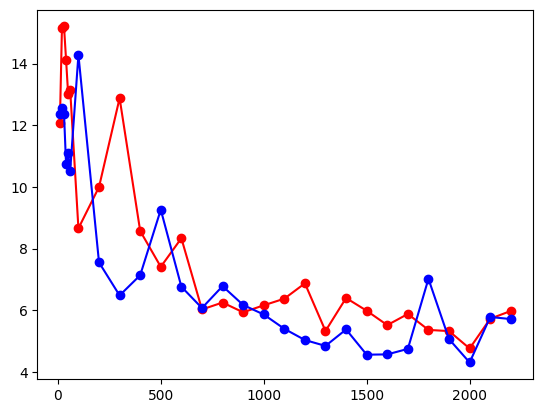

In [16]:
plt.plot(train_loss["Step"], train_loss["Value"], 'ro-')
plt.plot(eval_loss["Step"], eval_loss["Value"], 'bo-')
plt.show()